<a href="https://colab.research.google.com/github/yenlung/Generative-AI-Book/blob/main/%E5%86%92%E9%9A%AA04_%E8%B6%85%E5%BC%B7%E5%A4%96%E6%8E%9BControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ControlNet 可以做很多有趣的事, 所以一出來之後, 馬上變成非常熱門的技術。在 `diffusers` 套件要用 ControlNet 其實是件容易的事, 不過因為 ControlNet 比較耗資源, 我們以其中一個任務來介紹 ControlNet 使用方式及注意事項。

### 1. 安裝必要套件

In [2]:
!pip install transformers
!pip install diffusers["torch"]
!pip install accelerate
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 27.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.0 MB/s eta 0:00:00


### 2. ControlNet 的一條龍服務

ControlNet 還是要選用一個模型, 再依我們想在 ControlNet 做的事, 把相關的套件讀進來。這裡示範的是 `canny`, 也就是「坎尼邊緣檢測」的 ControlNet。其實意思就是, 我們給 ControlNet 一個黑底的描邊圖, 然後 ControlNet 就依此「畫出」一張圖來。



In [3]:
import torch

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

這裡我們就是選用 `canny` 的 ControlNet, Stable Diffusion 模型用 `chilloutmix`。

In [4]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stablediffusionapi/chilloutmix", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


### 3. 選擇性的設定

接著是一些選擇性, 但又讓進行更快速、或更省資源的設定。首先是風評很好, 可以在比較少步就可以完成畫圖的 scheduler -- UniPC。

In [5]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

再來是比較技巧的部份。還記得之前我們都會設 `pipe.to('cuda')` 嗎? 意思就是我們一條龍服務 `pipe` 要用 CUDA 加速。這聽來非常合理, 但是 Stable Diffusion 的一條龍服務中, 其實依序執行很多不同的模型, 從 CLIP 文字處理, 生成一組 latent tensor, 再執行 denoise 的過程, 再送 VAE 把圖生出來等等。其實 GPU 在執行完一個任務中間應該有個「休息」時間, 說得這麼多, 意思就是, 尤其是像 ControlNet 這很費資源的, 我們應該讓 GPU 自動休息, 「不要」設 `.to('cuda')`。

In [6]:
pipe.enable_model_cpu_offload()

### 4. 讀入描邊圖

我們來用 `diffusers` 內建工具把圖讀進來。

In [7]:
from diffusers.utils import load_image

In [8]:
image_url = "https://github.com/yenlung/Generative-AI-Book/raw/main/images/canny_image.png"

In [9]:
canny_image = load_image(image_url)

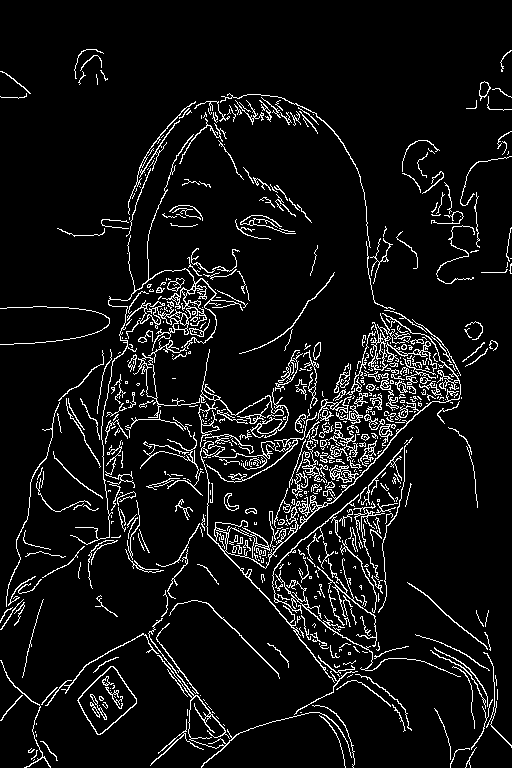

In [10]:
canny_image

### 4. 正式用 ControlNet

In [16]:
r = np.random.randint(0, 999999999)

In [17]:
generator = torch.Generator(device="cpu").manual_seed(r)

In [18]:
prompt = "masterpiece, 8k, highres, 1girl eating a coffee flavor ice cream cone with a red bag on her lap and people sitting in the background"

In [19]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    generator=generator,
    num_inference_steps=20
)

  0%|          | 0/20 [00:00<?, ?it/s]

看一下結果 (和以前一樣, 在輸出的 `.images[0]`)

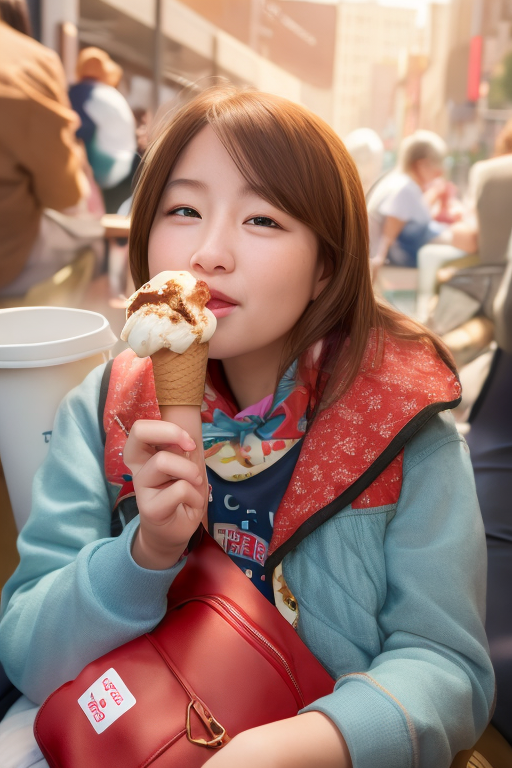

In [20]:
output.images[0]